In [1]:
import requests
import json
import pandas as pd
import numpy as np
from functools import reduce
import datetime
import wbdata
import plotly.express as px
import plotly.io as pio
pio.renderers.default = "notebook" # use "pio.renderers" to see the default renderer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error

In [2]:
pd.set_option("display.max_rows", None, "display.max_columns", None)

# Debt forecasting
- Adapted from this: https://builtin.com/data-science/time-series-forecasting-python

### Load data

In [3]:
# load data
df = pd.read_csv("debt_data.csv",index_col="date", infer_datetime_format=True, parse_dates=True)

In [4]:
# resample to enforce index frequency
# needed for later steps
# reference to frequency strings: https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#dateoffset-objects
df = df.resample("AS").mean()
# fill NaNs with bfills
df = df.fillna(method="bfill")
# drop cols that only contain NaNs
df = df.dropna(how='all', axis=1)
# drop rows that only contain NaNs
df = df.dropna(how='all', axis=0)
# convert column types from np.float64 to np.int64
df = df.astype(np.int64)
df.head()

,Afghanistan,Angola,Albania,Argentina,Armenia,Azerbaijan,Burundi,Benin,Burkina Faso,Bangladesh,Bulgaria,Bosnia and Herzegovina,Belarus,Belize,Bolivia,Brazil,Bhutan,Botswana,Central African Republic,China,Cote d'Ivoire,Cameroon,"Congo, Dem. Rep.","Congo, Rep.",Colombia,Comoros,Cabo Verde,Costa Rica,Djibouti,Dominica,Dominican Republic,Algeria,Ecuador,"Egypt, Arab Rep.",Eritrea,Ethiopia,Fiji,Gabon,Georgia,Ghana,Guinea,"Gambia, The",Guinea-Bissau,Grenada,Guatemala,Guyana,Honduras,Haiti,Indonesia,India,"Iran, Islamic Rep.",Jamaica,Jordan,Kazakhstan,Kenya,Kyrgyz Republic,Cambodia,Lao PDR,Lebanon,Liberia,St. Lucia,Sri Lanka,Lesotho,Morocco,Moldova,Madagascar,Maldives,Mexico,North Macedonia,Mali,Myanmar,Montenegro,Mongolia,Mozambique,Mauritania,Mauritius,Malawi,Niger,Nigeria,Nicaragua,Nepal,Pakistan,Panama,Peru,Philippines,Papua New Guinea,Paraguay,Romania,Russian Federation,Rwanda,Sudan,Senegal,Solomon Islands,Sierra Leone,El Salvador,Somalia,Serbia,Sao Tome and Principe,Eswatini,Syrian Arab Republic,Chad,Togo,Thailand,Tajikistan,Turkmenistan,Timor-Leste,Tonga,Tunisia,Turkey,Tanzania,Uganda,Ukraine,Uzbekistan,St. Vincent and the Grenadines,Vietnam,Vanuatu,Samoa,Kosovo,"Yemen, Rep.",South Africa,Zambia,Zimbabwe
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1960-01-01,979344507,7288778066,511485756,5893191433,133922025,35540000,14970400,43206645,20789505,146504255,772737948,2408825764,968283686,4084800,716253874,5984162468,325908,17358400,24142239,5798013609,373548111,145926448,345217589,118823126,2337070268,1172240,39376101,320105203,2594794,14433362,389548000,939559305,402122588,1801624657,29056800,169291507,11665440,103822382,79312483,572138164,336538268,5076000,0,16048000,192905000,82870994,158332049,52164000,3432691278,8425121119,4618942613,981947821,119092816,34977844,477537524,5527412,163589000,8345623,64232860,162259998,15516307,435678442,8122200,984947643,38504010,485146240,8884310,7097271963,1041777825,247329389,163680999,879825840,354767148,1318271500,26315139,31738400,135209089,31677128,836680592,242870748,3800810,3406742576,228889000,3299813044,2196027768,208775480,144131808,30147075,79671384011,4878977,385062510,145252948,11479143,61400031,205547537,73220144,2329427795,2183745,37033600,5388704719,35194310,39801356,1000572108,9731000,276435325,76035317,24548074,603200003,2746453200,197359339,151676389,550691959,59702042,1455000,25579000,3008900,2682000,75993698,48815506,21670999666,813521836,232362560
1961-01-01,979344507,7288778066,511485756,5893191433,133922025,35540000,14970400,43206645,20789505,146504255,772737948,2408825764,968283686,4084800,716253874,5984162468,325908,17358400,24142239,5798013609,373548111,145926448,345217589,118823126,2337070268,1172240,39376101,320105203,2594794,14433362,389548000,939559305,402122588,1801624657,29056800,169291507,11665440,103822382,79312483,572138164,336538268,5076000,0,16048000,192905000,82870994,158332049,52164000,3432691278,8425121119,4618942613,981947821,119092816,34977844,477537524,5527412,163589000,8345623,64232860,162259998,15516307,435678442,8122200,984947643,38504010,485146240,8884310,7097271963,1041777825,247329389,163680999,879825840,354767148,1318271500,26315139,31738400,135209089,31677128,836680592,242870748,3800810,3406742576,228889000,3299813044,2196027768,208775480,144131808,30147075,79671384011,4878977,385062510,145252948,11479143,61400031,205547537,73220144,2329427795,2183745,37033600,5388704719,35194310,39801356,1000572108,9731000,276435325,76035317,24548074,603200003,2746453200,197359339,151676389,550691959,59702042,1455000,25579000,3008900,2682000,75993698,48815506,21670999666,813521836,232362560
1962-01-01,979344507,7288778066,511485756,5893191433,133922025,35540000,14970400,43206645,20789505,146504255,772737948,2408825764,968283686,4084800,716253874,5984162468,325908,17358400,24142239,5798013609,373548111,145926448,345217589,118823126,2337070268,1172240,39376101,320105203,259479

### Setup

In [5]:
sns.set()

In [6]:
country_name = "Bulgaria"

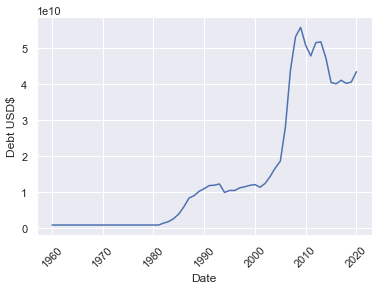

In [7]:
# test plot
plt.ylabel('Debt USD$')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.plot(df.index, df[country_name])

In [8]:
# train/test split
date_split = pd.to_datetime("2017-01-01", format='%Y-%m-%d')
train = df[country_name][df.index <= date_split]
test = df[country_name][df.index >= date_split]

In [9]:
# deal with missing values
train = train.fillna(method="bfill")
test = test.fillna(method="bfill")

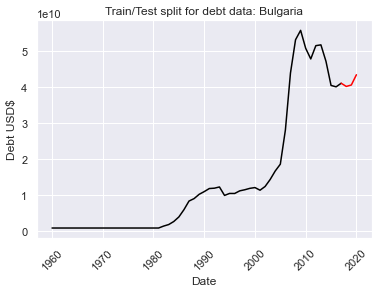

In [10]:
# plot split
plt.plot(train, color = "black")
plt.plot(test, color = "red")
plt.ylabel('Debt USD$')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test split for debt data: "+ country_name)
plt.show()

In [11]:
y = train

### ARMA

In [12]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [13]:
ARMAmodel = SARIMAX(y, order = (1, 0, 1))

In [14]:
ARMAmodel = ARMAmodel.fit()

/Users/userfriendly/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:965: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.



In [15]:
y_pred = ARMAmodel.get_forecast(len(test.index))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = ARMAmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = test.index
y_pred_out = y_pred_df["Predictions"] 
y_pred_out

date
2017-01-01    3.976515e+10
2018-01-01    3.928743e+10
2019-01-01    3.881544e+10
2020-01-01    3.834912e+10
Freq: AS-JAN, Name: Predictions, dtype: float64

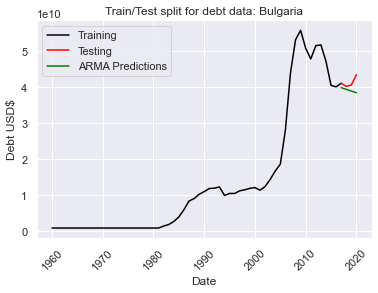

In [16]:
plt.plot(train, color = "black", label = 'Training')
plt.plot(test, color = "red", label = 'Testing')
plt.plot(y_pred_out, color='green', label = 'ARMA Predictions')
plt.ylabel('Debt USD$')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test split for debt data: "+ country_name)
plt.legend()

In [17]:
arma_rmse = np.sqrt(mean_squared_error(test.values, y_pred_df["Predictions"]))
print("RMSE: ",arma_rmse)

RMSE:  2738124961.6800194


### ARIMA

In [18]:
from statsmodels.tsa.arima.model import ARIMA

In [19]:
ARIMAmodel = ARIMA(y, order = (5, 4, 2))
ARIMAmodel = ARIMAmodel.fit()

/Users/userfriendly/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:977: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



In [20]:
y_pred = ARIMAmodel.get_forecast(len(test.index))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = ARIMAmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = test.index
y_pred_out = y_pred_df["Predictions"] 
y_pred_out

date
2017-01-01    3.821716e+10
2018-01-01    3.110021e+10
2019-01-01    2.354885e+10
2020-01-01    2.003593e+10
Freq: AS-JAN, Name: Predictions, dtype: float64

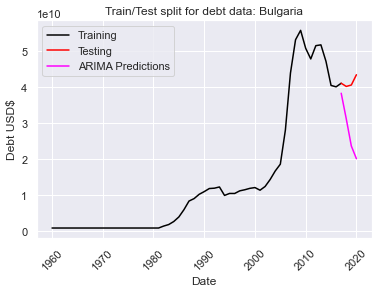

In [21]:
plt.plot(train, color = "black", label = 'Training')
plt.plot(test, color = "red", label = 'Testing')
plt.plot(y_pred_out, color='Magenta', label = 'ARIMA Predictions')
plt.ylabel('Debt USD$')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test split for debt data: "+ country_name)
plt.legend()

In [22]:
arima_rmse = np.sqrt(mean_squared_error(test.values, y_pred_df["Predictions"]))
print("RMSE: ",arima_rmse)

RMSE:  15162088623.189957


### SARIMA

In [23]:
SARIMAXmodel = SARIMAX(y, order = (3, 2, 2), seasonal_order=(2,2,2,12))
SARIMAXmodel = SARIMAXmodel.fit()

/Users/userfriendly/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:865: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.

/Users/userfriendly/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [24]:
y_pred = SARIMAXmodel.get_forecast(len(test.index))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = SARIMAXmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = test.index
y_pred_out = y_pred_df["Predictions"] 
y_pred_out

date
2017-01-01    4.330399e+10
2018-01-01    4.626835e+10
2019-01-01    4.539248e+10
2020-01-01    4.544700e+10
Freq: AS-JAN, Name: Predictions, dtype: float64

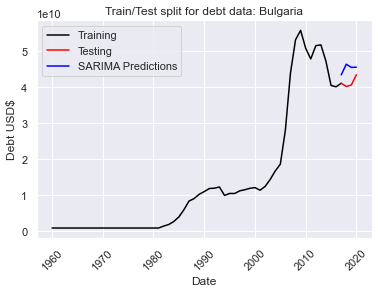

In [25]:
plt.plot(train, color = "black", label = 'Training')
plt.plot(test, color = "red", label = 'Testing')
plt.plot(y_pred_out, color='Blue', label = 'SARIMA Predictions')
plt.ylabel('Debt USD$')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test split for debt data: "+ country_name)
plt.legend()

In [26]:
sarima_rmse = np.sqrt(mean_squared_error(test.values, y_pred_df["Predictions"]))
print("RMSE: ",sarima_rmse)

RMSE:  4233656732.502833
